In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from app_extractor import PreProcess
from app_utils import *
import numpy as np



In [3]:
df=pd.read_json('./datasets/Sports_and_Outdoors_5.json',lines=True)
df.columns

Index(['reviewerID', 'asin', 'reviewerName', 'helpful', 'reviewText',
       'overall', 'summary', 'unixReviewTime', 'reviewTime'],
      dtype='object')

In [14]:
df.isna().sum()

reviewerID           0
asin                 0
reviewerName      1402
helpful              0
reviewText           0
overall              0
summary              0
unixReviewTime       0
reviewTime           0
dtype: int64

**Mostramos registros que no son NaN pero estan vacios que es lo que filtra nuestra regex ^\s*$**

In [4]:
df.loc[df['reviewText'].str.contains(r'^\s*$', na=False, regex=True), 'reviewText']

1412       
1760       
1908       
2908       
2957       
         ..
290356     
291229     
293458     
293462     
293961     
Name: reviewText, Length: 123, dtype: object

In [5]:
df[df['reviewerName'].isna()].head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
154,A26EQ8U96JA92T,B00000IURU,NaN,"[0, 0]",This was a hit at a 4yr old birthday party. T...,5,Perfect for the 3-6 yr old crowd,1405123200,"07 12, 2014"
165,A383XURHVF8ON6,B00000J6JO,NaN,"[0, 0]",The main benefit of this putting mat is the ba...,3,Worth it for the ball return only,1405296000,"07 14, 2014"
250,A2V1MDBW2NKDHX,B00004SQM9,NaN,"[0, 0]","Not a substitute for a proper locker or safe, ...",5,"Secure, simple, won't scratch your finish, won...",1405209600,"07 13, 2014"
770,A3GN5AKTOU4ROG,B00004YVBA,NaN,"[0, 0]",Arrived in good condition and as advertised.I ...,5,Arrived in good condition and as advertised.,1287792000,"10 23, 2010"
771,A31H0N1UPQP62A,B00004YVBA,NaN,"[0, 0]",It's a swiss army and it's just as good as any...,5,It's a swiss army.,1204848000,"03 7, 2008"


### 📝 Manejo de Datos Faltantes en Reviews  

Para garantizar la integridad del análisis, las reseñas (`reviewText`) que estaban vacías o contenían valores `NaN` fueron completadas utilizando el contenido del campo `summary`.  
Esto permitió evitar la pérdida de información y mantener la coherencia en el procesamiento del texto.  

📌 **Beneficio:** Se preservó el máximo de datos disponibles para el entrenamiento del modelo, asegurando una mejor representación del contenido.  

In [6]:
df['reviewText'] = df.apply(lambda row: remplazar_review(row), axis=1)

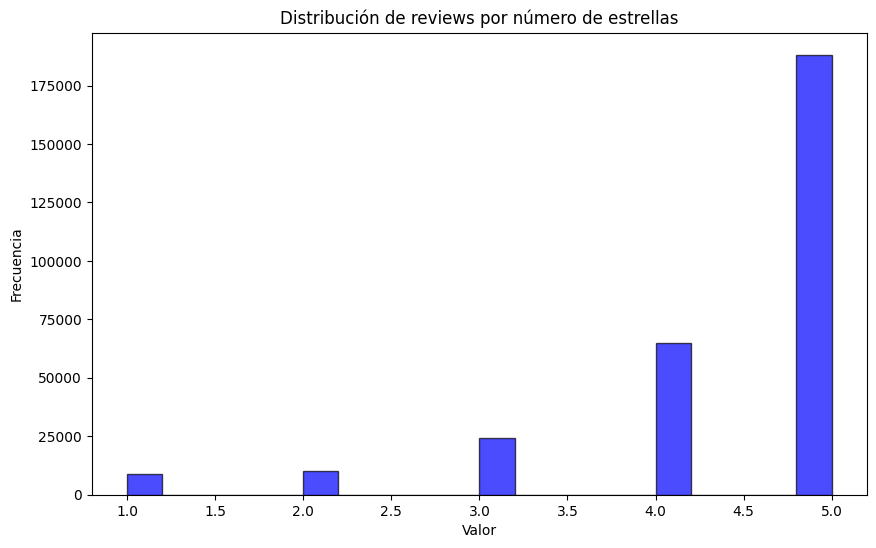

In [7]:
display_histogram(df['overall'],'Distribución de reviews por número de estrellas')

In [8]:
df['overall'].describe()

count    296337.000000
mean          4.393451
std           0.986905
min           1.000000
25%           4.000000
50%           5.000000
75%           5.000000
max           5.000000
Name: overall, dtype: float64

Interpretación global <br>
La media es 4.39, lo que sugiere una tendencia a calificaciones altas.<br>
La mediana es 5 y los cuartiles 50% y 75% son 5, lo que indica que la gran mayoría de las reseñas son muy positivas (valoración 5).<br>
La desviación estándar de aproximadamente 0.99 muestra que, aunque en promedio la calificación es alta, hay cierta variabilidad, aunque pequeña.<br>
La mayoría de las reseñas tienen calificaciones muy positivas<br>

*Existe un fuerte desbalance entre mis clases lo que puede sesgar el rendimiento del modelo hacia mi clase mayoritaria la 1 (4 y 5), lo debo tener en cuenta para combatir este efecto*

In [5]:
df['overall']=df['overall'].apply(lambda x: map_sentiment(x))

In [10]:
df['overall'].describe()

count    296337.000000
mean          0.853815
std           0.353292
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           1.000000
Name: overall, dtype: float64

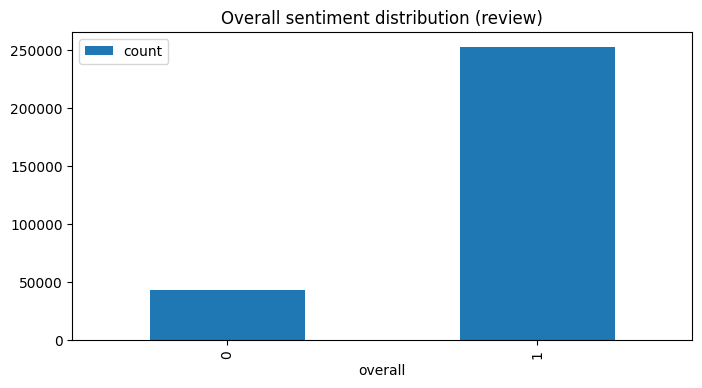

In [ ]:
aux_df = pd.DataFrame(df['overall'].value_counts(sort=False).sort_index())
aux_df = aux_df.plot(kind='bar', title='Overall sentiment distribution (review)', figsize=(8, 4))

In [10]:
print(f'REVIEWS NEGATIVAS: {len(df[df['overall']==0])}')
print(f'REVIEWS POSITIVAS: {len(df[df['overall']==1])}')

REVIEWS NEGATIVAS: 43320
REVIEWS POSITIVAS: 253017


In [11]:
df_study=df.rename(columns={
    'reviewText':'reviewText',
    'overall':'sentiment'
})

df_study['reviewText']=df_study['reviewText'].astype(str)
df_study['sentiment']=df_study['sentiment'].astype(int)

In [12]:
df_ = df_study[['reviewText','sentiment']]

In [13]:
df_.head()

,reviewText,sentiment
0,This came in on time and I am veru happy with ...,1
1,I had a factory Glock tool that I was using fo...,1
2,If you don't have a 3/32 punch or would like t...,1
3,This works no better than any 3/32 punch you w...,1
4,I purchased this thinking maybe I need a speci...,1


In [15]:
df_train, df_test = train_test_split(df_,test_size=.20,random_state=0,stratify=df_['sentiment'])
df_train.to_csv('./datasets/train_dataset.csv', index=False)
df_test.to_csv('./datasets/test_dataset.csv', index=False)

In [16]:
print("Distribución en conjunto de entrenamiento:")
print(df_train['sentiment'].value_counts(normalize=True))
print("\nDistribución en conjunto de prueba:")
print(df_test['sentiment'].value_counts(normalize=True))

Distribución en conjunto de entrenamiento:
sentiment
1    0.853815
0    0.146185
Name: proportion, dtype: float64

Distribución en conjunto de prueba:
sentiment
1    0.853817
0    0.146183
Name: proportion, dtype: float64


In [17]:
df_train.isna().sum()

reviewText    0
sentiment     0
dtype: int64

In [18]:
preprocess=PreProcess()

In [22]:
df_train['reviewTextProcess']=df_train['reviewText'].apply(preprocess.preprocess_texts)

In [23]:

df_test['reviewTextProcess']=df_test['reviewText'].apply(preprocess.preprocess_texts)


In [24]:
df_train.to_csv('./datasets/train_process_dataset.csv', index=False)
df_test.to_csv('./datasets/test_process_dataset.csv', index=False)

In [25]:
df_train.head()

,reviewText,sentiment,reviewTextProcess
291276,Surprisingly clear optics for the price. Very...,1,surprisingly clear optic price accurate perfec...
50705,I've owned the Schwinn 430 Elliptical Trainer ...,1,schwinn elliptical trainer month far not pleas...
232792,"The price, you can't ask for more. I installed...",1,price not ask instal daughter sig mosquito lov...
181419,"this is a pretty awesome, the blade is not top...",0,pretty awesome blade not metal compare swiss k...
121148,I use theses all the time at the gym. I will a...,1,gym admit no grip strength like lift heavy wei...


In [2]:
corpus= pd.read_csv('./datasets/train_dataset.csv')


In [3]:
corpus['reviewText'].isna().sum()

0

In [4]:
get_ngrams(corpus['reviewText'])

[(('work', 'well'), 3351),
 (('work', 'great'), 3117),
 (('highly', 'recommend'), 2020),
 (('good', 'quality'), 1269),
 (('look', 'like'), 1233),
 (('work', 'fine'), 1134),
 (('high', 'quality'), 1121),
 (('5', 'star'), 1108),
 (('really', 'like'), 1087),
 (('feel', 'like'), 1086),
 (('much', 'well'), 1079),
 (('great', 'product'), 1024),
 (('water', 'bottle'), 1008),
 (('light', 'weight'), 898),
 (('long', 'time'), 880)]

In [5]:
get_ngrams(corpus['reviewText'],n=3)

[(('last', 'long', 'time'), 366),
 (('give', '5', 'star'), 355),
 (('give', '4', 'star'), 246),
 (('well', 'worth', 'money'), 204),
 (('worth', 'every', 'penny'), 150),
 (('red', 'dot', 'sight'), 147),
 (('work', 'like', 'charm'), 141),
 (('highly', 'recommend', 'product'), 141),
 (('first', 'aid', 'kit'), 140),
 (('work', 'really', 'well'), 140),
 (('fit', 'like', 'glove'), 124),
 (('feel', 'good', 'hand'), 109),
 (('well', 'worth', 'price'), 106),
 (('hold', 'edge', 'well'), 102),
 (('swiss', 'army', 'knife'), 100)]

In [6]:
palabas_most=get_ngrams(corpus['reviewText'],n=1)

In [7]:
palabas_most

[(('well',), 27122),
 (('good',), 22285),
 (('great',), 20423),
 (('work',), 20028),
 (('like',), 19927),
 (('buy',), 15999),
 (('knife',), 15191),
 (('fit',), 14296),
 (('go',), 13083),
 (('need',), 12614),
 (('time',), 11907),
 (('look',), 11603),
 (('easy',), 11497),
 (('little',), 10715),
 (('light',), 10421)]

In [8]:
bigram_dict = {" ".join(bigram): freq for bigram, freq in palabas_most}

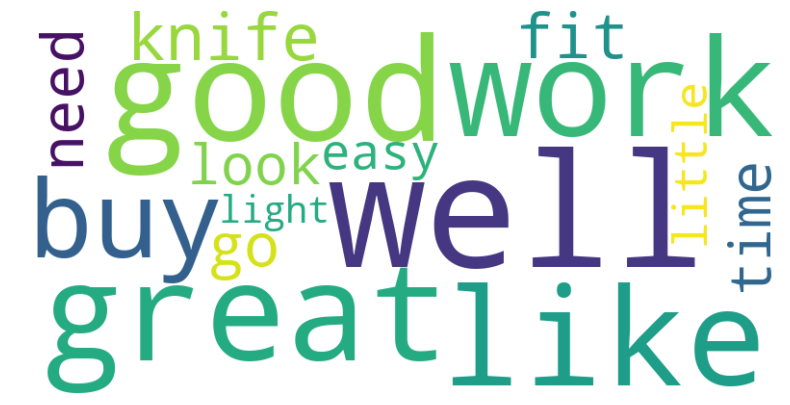

In [9]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

wordcloud = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(bigram_dict)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")  
plt.show()